# Beat The Bookies: Predicting EPL Matches
_Team C_

__Mohammad Ali Syed, Abdul Al-Fahim, Dylan Hoi, Henry Chen, Chris Wong & Yolanne Lee__

**Contents:**

[Section 1](#section1): Introduction

[Section 2](#section2): Data Import

[Section 3](#section3): Data Transformation & Exploration

[Section 4](#section4): Methodology Overview

[Section 5](#section5): Model Training & Validation

[Section 6](#section6): Results

[Section 7](#section7): Final Predictions on Test Set

## Introduction
<a name='section1'></a>

## Data Import
<a name='section2'></a>

In [1]:
#Import packages
import math
import numpy as np
import pandas as pd
import datetime as datetime
import seaborn as sns
from collections import Counter

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report,confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA

#For Visualisation
from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image

#For Model Selection
from sklearn.model_selection import RepeatedStratifiedKFold, KFold, RepeatedKFold
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt


In [2]:
#Load data

#Change this to your directory
dirName = 'Data_Files/'
filePath = dirName + 'epl-training.csv'

data = pd.read_csv(filePath)
#Remove empty nan columns at the end
data = data.iloc[:, 0:22]
pd.set_option('display.max_columns', None)
data.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,16/08/08,Arsenal,West Brom,1,0,H,1,0,H,H Webb,24,5,14,4,11,8,7,5,0,0,0,0
1,16/08/08,Bolton,Stoke,3,1,H,3,0,H,C Foy,14,8,8,2,13,12,4,3,1,2,0,0
2,16/08/08,Everton,Blackburn,2,3,A,1,1,D,A Marriner,10,15,5,11,11,9,3,5,2,2,0,0
3,16/08/08,Hull,Fulham,2,1,H,1,1,D,P Walton,11,12,6,6,10,9,5,6,3,0,0,0
4,16/08/08,Middlesbrough,Tottenham,2,1,H,0,0,D,M Atkinson,14,8,10,5,11,12,7,9,1,2,0,0


## Data Transformation & Exploration
<a name='section3'></a>

In [3]:
#Helper Functions

def corr_matrix(X, feature):
    corr= X.corr()
    corr_y = abs(corr[feature])
    highest_corr = corr_y[corr_y >0.2]
    highest_corr.sort_values(ascending=True)
    return highest_corr

def rf_model(X_train, X_test, y_train, y_test):
    rf=RandomForestClassifier(random_state = 42)
    rf.fit(X_train, y_train)
    preds = rf.predict(X_test)
    accuracy = calc_accuracy(preds, y_test)
    return rf, preds, accuracy

def feat_importances(X_train, rf):
    feature_importances = list(zip(X_train, rf.feature_importances_))
    feature_importances_ranked = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    return feature_importances_ranked

def select_feat(X_train, y_train):
    feature_selector = SelectFromModel(RandomForestClassifier(random_state = 42)).fit(X_train, y_train)
    selected_feat= X_train.columns[(feature_selector.get_support())]
    return selected_feat

def calc_accuracy(preds, labels):
    accuracy = accuracy_score(labels, preds) * 100
    return accuracy

def rf_tree_visualiser(rf, featuresetName, feature_names):
    tree = rf.estimators_[10]  #Take 10th random tree
    export_graphviz(tree, out_file = featuresetName + '.dot', feature_names = list(feature_names),
                    rounded = True, proportion = False, 
                    precision = 2, filled = True, max_depth = 3)
    call(['dot', '-Tpng', featuresetName + '.dot', '-o', featuresetName + '.png'],shell=True)
    return featuresetName + '.png'

def scatter(data, title, xlabel, ylabel):
    # Assume data is an array of tuples
    x, y = zip(*data)
    # s is the area of the circles in the plot
    plt.scatter(x, y, s=50)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    
# https://towardsdatascience.com/stop-one-hot-encoding-your-time-based-features-24c699face2f
def transformation(column):
    max_value = column.max()
    sin_values = [math.sin((2*math.pi*x)/max_value) for x in list(column)]
    cos_values = [math.cos((2*math.pi*x)/max_value) for x in list(column)]
    return sin_values, cos_values

In [4]:
############################################# Feature Visualisation
# Visualise correlations between different statistics
from pandas.plotting import scatter_matrix

# Sort data by teams
teams = {}
referees = {}
for i in data.groupby('HomeTeam').mean().T.columns:
    teams[i] = []
for i in data.groupby('Referee').mean().T.columns:
    referees[i] = []

# Team Summary Statistics
home_team_stats = pd.DataFrame()
away_team_stats = pd.DataFrame()

teams = pd.unique(data[["HomeTeam"]].values.ravel())

for team in teams:
    # Compute summary stats as home team
    team_stats = data[(data["HomeTeam"] == team)]
    team_stats = team_stats.iloc[:, [3, 6, 10, 12, 14, 16, 18, 20]]
    team_stats = team_stats.sum()

    performance = data[(data["HomeTeam"] == team)].iloc[:, 5]
    num_vals = len(performance)
    
    performance = performance.value_counts()
    performance_keys = performance.keys()
    performance_values = performance.values
    performance = zip(performance.keys(), performance.values)
    
    for key, value in performance:
        metric = value/num_vals
        
        if key == "H":
            team_stats["Win Rate"] = metric
            
        elif key == "A":
            team_stats["Lose Rate"] = metric
        
        else:
            team_stats["Draw Rate"] = metric

    home_team_stats[team] = pd.DataFrame(team_stats) ##causing problems

    # Compute summary stats as away team
    team_stats = data[(data["AwayTeam"] == team)]
    team_stats = team_stats.iloc[:, [4, 7, 11, 13, 15, 17, 19, 21]]
    team_stats = team_stats.sum()

    performance = data[(data["AwayTeam"] == team)].iloc[:, 5]
    num_vals = len(performance)

    performance = performance.value_counts()
    performance_keys = performance.keys()
    performance_values = performance.values
    performance = zip(performance.keys(), performance.values)
    
    for key, value in performance:
        metric = value/num_vals
        
        if key == "A":
            team_stats["Win Rate"] = metric
            
        elif key == "H":
            team_stats["Lose Rate"] = metric
        
        else:
            team_stats["Draw Rate"] = metric


    away_team_stats[team] = pd.DataFrame(team_stats)

# Sort by strongest to weakest team, by win rate
home_team_stats = home_team_stats.sort_values(by='Win Rate', axis=1, ascending=False)
away_team_stats = away_team_stats.sort_values(by='Win Rate', axis=1, ascending=False)
home_team_stats
#Interesting to note, Man U ranked lower on every metric except fouls and yellow cards compared to Chelsea but had higher win rate -> could suggest the more aggressive the team, the higher the win rate
# print(home_team_stats.iloc[:, 0])
# print(away_team_stats.iloc[:, 0])
# print(np.array(home_team_stats.iloc[:, 0]) - np.array(away_team_stats.iloc[:, 0]))

,Man City,Man United,Chelsea,Arsenal,Liverpool,Tottenham,Everton,Leicester,Stoke,Leeds,West Ham,Fulham,Sheffield United,Newcastle,Swansea,Blackburn,Southampton,Watford,Birmingham,Wolves,Bournemouth,Bolton,Burnley,Portsmouth,Crystal Palace,Norwich,West Brom,Aston Villa,Hull,Sunderland,Wigan,Cardiff,Brighton,Blackpool,QPR,Middlesbrough,Reading,Huddersfield
FTHG,620.000000,513.000000,518.000000,501.000000,520.000000,447.000000,406.000000,212.000000,248.000000,28.000000,332.000000,204.000000,36.000000,290.000000,179.000000,98.000000,247.000000,120.000000,38.000000,138.000000,136.000000,104.000000,143.000000,50.000000,165.000000,115.000000,240.000000,230.000000,107.000000,200.000000,106.000000,41.000000,85.000000,30.000000,60.000000,34.000000,23.000000,26.000000
HTHG,274.000000,236.000000,245.000000,212.000000,249.000000,200.000000,181.000000,92.000000,115.000000,11.000000,152.000000,84.000000,17.000000,122.000000,73.000000,43.000000,119.000000,40.000000,14.000000,54.000000,58.000000,48.000000,67.000000,16.000000,70.000000,50.000000,109.000000,109.000000,52.000000,98.000000,46.000000,14.000000,34.000000,15.000000,24.000000,16.000000,7.000000,14.000000
HS,4299.000000,3957.000000,4358.000000,3919.000000,4378.000000,4148.000000,3463.000000,1822.000000,2181.000000,265.000000,2993.000000,2028.000000,394.000000,2784.000000,1647.000000,949.000000,2407.000000,1185.000000,379.000000,1433.000000,1191.000000,1036.000000,1492.000000,558.000000,1891.000000,1185.000000,2377.000000,2322.000000,1106.000000,2072.000000,1290.000000,458.000000,948.000000,253.000000,843.000000,429.000000,161.000000,410.000000
HST,1874.000000,1830.000000,1933.000000,1809.000000,1868.000000,1874.000000,1493.000000,611.000000,854.000000,107.000000,1213.000000,978.000000,129.000000,1134.000000,678.000000,501.000000,864.000000,366.000000,186.000000,619.000000,399.000000,613.000000,527.000000,312.000000,610.000000,482.000000,1002.000000,987.000000,438.000000,884.000000,693.000000,142.000000,272.000000,134.000000,356.000000,186.000000,85.000000,112.000000
HF,2524.000000,2701.000000,2543.000000,2548.000000,2418.000000,2547.000000,2680.000000,1395.000000,2191.000000,227.000000,2374.000000,1587.000000,419.000000,2237.000000,1280.000000,957.000000,1855.000000,1186.000000,390.000000,1215.000000,872.000000,956.000000,1375.000000,435.000000,1723.000000,948.000000,2043.000000,2102.000000,1180.000000,1872.000000,1127.000000,362.000000,833.000000,216.000000,602.000000,417.000000,169.000000,394.000000
HC,1908.000000,1643.000000,1713.000000,1782.000000,1826.000000,1687.000000,1513.000000,771.000000,1002.000000,118.000000,1249.000000,844.000000,224.000000,1137.000000,724.000000,378.000000,987.000000,446.000000,192.000000,671.000000,540.000000,423.000000,630.000000,231.000000,859.000000,489.000000,1055.000000,1159.000000,459.000000,876.000000,573.000000,205.000000,407.000000,94.000000,285.000000,198.000000,104.000000,187.000000
HY,328.000000,357.000000,319.000000,364.000000,262.000000,342.000000,347.000000,165.000000,317.000000,33.000000,345.000000,211.000000,62.000000,326.000000,188.000000,121.000000,229.000000,205.000000,60.000000,173.000000,152.000000,108.000000,202.000000,68.000000,237.000000,143.000000,298.000000,292.000000,143.000000,301.000000,143.000000,58.000000,126.000000,22.000000,87.000000,69.000000,21.000000,53.000000
HR,16.000000,9.000000,15.000000,18.000000,10.000000,8.000000,12.000000,8.000000,14.000000,0.000000,11.000000,8.000000,2.000000,16.000000,6.000000,4.000000,16.000000,11.000000,3.000000,4.000000,5.000000,8.000000,0.000000,6.000000,5.000000,6.000000,10.000000,14.000000,12.000000,12.000000,4.000000,0.000000,4.000000,0.000000,9.000000,1.000000,1.000000,5.000000
Win Rate,0.753036,0.680162,0.651822,0.639676,0.627530,0.615385,0.497976,0.481203,0.426316,0.421053,0.412281,0.394737,0.394737,0.387560,0.383459,0.381579,0.380117,0.368421,0.368421,0.359649,0.357895,0.355263,0.353383,0.342105,0.328947,0.326316,0.326316,0.310526,0.305263,0.304094,0.294737,0.289474,0.289474,0.263

In [5]:
#Correlation matrix between full time goals and other features
highest_corr = corr_matrix(data, "FTHG")
print("FTHG: \n" + str(highest_corr))

highest_corr = corr_matrix(data, "FTAG")
print("FTAG: \n" + str(highest_corr))

FTHG: 
FTHG    1.000000
HTHG    0.686279
HS      0.291868
HST     0.447116
Name: FTHG, dtype: float64
FTAG: 
FTAG    1.000000
HTAG    0.689755
AS      0.329803
AST     0.455887
Name: FTAG, dtype: float64


In [6]:
#Split dataset into input and output data

#Output variable
y = data.iloc[:, 5:6]
#Reformat y to make it suitable for LabelEncoder

y = np.array(y).reshape(len(y))
# #Encode y
# y = LabelEncoder().fit_transform(y) #################this needs to be done separately for train/test

#Input variables
#Remove give away columns such as goals scored
data_filtered = data.drop(labels = data.columns[[3, 4, 5, 6, 7, 8]], axis = 1)

In [7]:
#Data preprocessing

#Dates
data_filtered['Date'] = pd.to_datetime(data_filtered['Date'])
#year has been removed as we need to predict future results -> https://towardsdatascience.com/machine-learning-with-datetime-feature-engineering-predicting-healthcare-appointment-no-shows-5e4ca3a85f96
data_filtered['Month'] = data_filtered['Date'].dt.month
data_filtered['Week'] = data_filtered['Date'].dt.isocalendar().week
data_filtered['Day'] = data_filtered['Date'].dt.day
#Extract encoded dates
dates_split = data_filtered.iloc[:, 16:19]
#Remove encoded dates and original date column
data_filtered = data_filtered.drop(labels = data_filtered.columns[[0, 16, 17, 18]], axis = 1)

#Encode categorical data
encoder = OneHotEncoder(handle_unknown='ignore')

#Teams
home_t = data_filtered.iloc[:, 0:1]
home_t = encoder.fit_transform(home_t) #################does this need to be done separately?

away_t = data_filtered.iloc[:, 1:2]
away_t = encoder.fit_transform(away_t) #################does this need to be done separately?
data_filtered = data_filtered.drop(labels = data_filtered.columns[[0,1]], axis = 1)

#Referees 
ref = data_filtered.iloc[:, 0:1]
ref = encoder.fit_transform(ref)       #################does this need to be done separately?
data_filtered = data_filtered.drop(labels = data_filtered.columns[[0]], axis = 1)

#Re-stack columns
data_filtered = data_filtered.join(pd.DataFrame(ref.toarray()), rsuffix = '_ref')
data_filtered = data_filtered.join(pd.DataFrame(home_t.toarray()), rsuffix = '_home')
data_filtered = data_filtered.join(pd.DataFrame(away_t.toarray()), rsuffix = '_away')
data_filtered = dates_split.join(data_filtered)
data_filtered.columns = data_filtered.columns.astype(str)
data_filtered.head()

,Month,Week,Day,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,0_home,1_home,2_home,3_home,4_home,5_home,6_home,7_home,8_home,9_home,10_home,11_home,12_home,13_home,14_home,15_home,16_home,17_home,18_home,19_home,20_home,21_home,22_home,23_home,24_home,25_home,26_home,27_home,28_home,29_home,30_home,31_home,32_home,33_home,34_home,35_home,36_home,37_home,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37
0,8,33,16,24,5,14,4,11,8,7,5,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,8,33,16,14,8,8,2,13,12,4,3,1,2,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8,33,16,10,15,5,11,11,9,3,5,2,2,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8,33,16,11,12,6,6,10,9,5,6,3,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8,33,16,14,8,10,5,11,12,7,9,1,2,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [8]:
#Train model on entire featureset
X_train, X_test, y_train, y_test = train_test_split(data_filtered, y, test_size=0.3, random_state=42)

y_train = np.array(y_train).reshape(len(y_train))
y_test = np.array(y_test).reshape(len(y_test))
#Encode y
encoder = LabelEncoder().fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

rf, preds, base_accuracy = rf_model(X_train, X_test, y_train, y_test)
print("Accuracy on entire featureset: " + str(base_accuracy) + "%")


Accuracy on entire featureset: 57.827260458839405%


In [ ]:
#Print rf tree N.B. may not work without importing graphviz, random forest images will be on GitHub
Image(filename = rf_tree_visualiser(rf, 'featureSetTree', data_filtered.columns))

In [9]:
#Train model without Referee feature
data_filtered_no_ref = data_filtered.iloc[:, 0:15].join(data_filtered.iloc[:, 58:])
X_train, X_test, y_train, y_test = train_test_split(data_filtered_no_ref, y, test_size=0.3, random_state=42)

y_train = np.array(y_train).reshape(len(y_train))
y_test = np.array(y_test).reshape(len(y_test))
#Encode y
encoder = LabelEncoder().fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)


rf, preds, accuracy = rf_model(X_train, X_test, y_train, y_test)
print("Accuracy without Referee: " + str(accuracy) + "%")
print("Difference from before: " + str(accuracy - base_accuracy) + "%")
#Ref is having negative impact so remove
data_filtered = data_filtered_no_ref

Accuracy without Referee: 57.962213225371116%
Difference from before: 0.13495276653171118%


In [ ]:
#Print rf tree (no ref)
Image(filename = rf_tree_visualiser(rf, 'featureSetTreeNoRef', data_filtered_no_ref.columns))

In [10]:
#Train model without Date feature
data_filtered_no_date = data_filtered.iloc[:, 3:]
X_train, X_test, y_train, y_test = train_test_split(data_filtered_no_date, y, test_size=0.3, random_state=42)

y_train = np.array(y_train).reshape(len(y_train))
y_test = np.array(y_test).reshape(len(y_test))
#Encode y
encoder = LabelEncoder().fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)


rf, preds, accuracy = rf_model(X_train, X_test, y_train, y_test)
print("Accuracy without Dates: " + str(accuracy) + "%")
print("Difference from before: " + str(accuracy - base_accuracy) + "%")

Accuracy without Dates: 56.81511470985156%
Difference from before: -1.012145748987848%


In [ ]:
#Print rf tree (no dates)
Image(filename = rf_tree_visualiser(rf, 'featureSetTreeNoDate', data_filtered_no_date.columns))

In [11]:
#Train model on only in-game stats to identify most important ones
data_filtered_only_game_stats = data_filtered.iloc[:, 3:15]
X_train, X_test, y_train, y_test = train_test_split(data_filtered_only_game_stats, y, test_size=0.3, random_state=42)

y_train = np.array(y_train).reshape(len(y_train))
y_test = np.array(y_test).reshape(len(y_test))
#Encode y
encoder = LabelEncoder().fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)


rf, preds, all_stats_accuracy = rf_model(X_train, X_test, y_train, y_test)
print("Accuracy on all in-game stats: " + str(all_stats_accuracy) + "%")

Accuracy on all in-game stats: 55.06072874493927%


In [14]:
#Visualise and analyse initial results

#Display feature importances in descending order
feature_importances = feat_importances(X_train, rf)
print("Feature Importances: ")
[print('Feature: {:35} Importance: {}'.format(*pair)) for pair in feature_importances];

print("\nConfusion Matrix: ")
print(confusion_matrix(y_test, preds))
print("\nClassification Report: ")
print(classification_report(y_test, preds))
#Important note: AF/HF rank higher than HC/AC

Feature Importances: 
Feature: HST                                 Importance: 0.13373568693956137
Feature: AST                                 Importance: 0.11086929727346594
Feature: HS                                  Importance: 0.10711965963253876
Feature: AS                                  Importance: 0.10459574408160308
Feature: AF                                  Importance: 0.10278875719257885
Feature: HF                                  Importance: 0.10274903136845186
Feature: HC                                  Importance: 0.09664473425445547
Feature: AC                                  Importance: 0.09167319027635455
Feature: AY                                  Importance: 0.06454575651360132
Feature: HY                                  Importance: 0.0615627757744895
Feature: AR                                  Importance: 0.012278852078380604
Feature: HR                                  Importance: 0.011436514614518712

Confusion Matrix: 
[[244  46 127]
 [134  50 186]
 [1

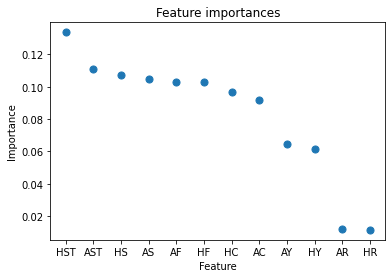

In [15]:
# Visualise feature importance
scatter(feature_importances, "Feature importances", "Feature", "Importance")

C:\Users\alisy\AppData\Local\Temp/ipykernel_7344/2076099105.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  attributes = data.drop(['Date','HomeTeam', 'AwayTeam', 'Referee','FTR'],1)


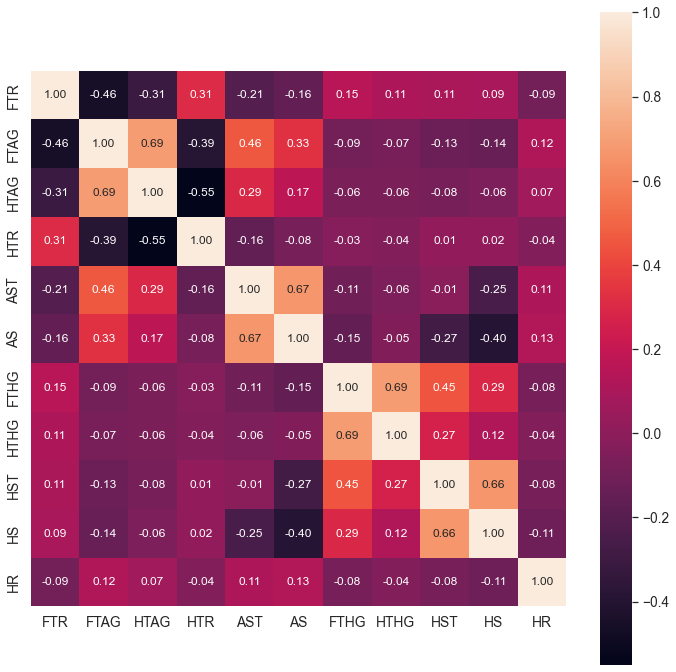

In [16]:
# plot Pearson Correlation Heatmap to see the top 10 features related to the match result FTR

def plotGraph(X_all, Y_all):

    train_data=pd.concat([X_all,Y_all],axis=1)

    #FTR correlation matrix
    plt.figure(figsize=(12,12))
    k = 11 # number of variables for heatmap
    cols = abs(train_data.astype(float).corr()).nlargest(k, 'FTR')['FTR'].index
    cm = np.corrcoef(train_data[cols].values.T)
    sns.set(font_scale=1.25)
    hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 12}, yticklabels=cols.values, xticklabels=cols.values)
    plt.show()

attributes = data.drop(['Date','HomeTeam', 'AwayTeam', 'Referee','FTR'],1)
attributes['HTR'] = attributes['HTR'].map({'H':1,'A':0,'D':2})
label = data['FTR']
label = label.map({'H':1,'A':0,'D':2})
plotGraph(attributes,label)

In [17]:
#Feature Selection
#change names and display selected features more nicely, ideally with their importance, gini impurity...
selected_feat = select_feat(X_train, y_train)
print(selected_feat)

Index(['HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC'], dtype='object')


In [18]:
#Train model on selected in-game stats only
indexes = []
for feat in selected_feat:
    indexes.append(data_filtered_only_game_stats.columns.get_loc(feat))
    
data_filtered_filtered_game_stats = data_filtered_only_game_stats.iloc[:, indexes]

X_train, X_test, y_train, y_test = train_test_split(data_filtered_filtered_game_stats, y, test_size=0.3, random_state=42)

y_train = np.array(y_train).reshape(len(y_train))
y_test = np.array(y_test).reshape(len(y_test))
#Encode y
encoder = LabelEncoder().fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)


rf, preds, reduced_stats_accuracy = rf_model(X_train, X_test, y_train, y_test)
print("Accuracy on reduced in-game stats: " + str(reduced_stats_accuracy) + "%")
print("Difference compared to all in-game stats: " + str(reduced_stats_accuracy - all_stats_accuracy) + "%")

print("\nConfusion Matrix: ")
print(confusion_matrix(y_test, preds))
print("\nClassification Report: ")
print(classification_report(y_test, preds))

Accuracy on reduced in-game stats: 54.79082321187584%
Difference compared to all in-game stats: -0.26990553306342946%

Confusion Matrix: 
[[234  39 144]
 [107  64 199]
 [118  63 514]]

Classification Report: 
              precision    recall  f1-score   support

           0       0.51      0.56      0.53       417
           1       0.39      0.17      0.24       370
           2       0.60      0.74      0.66       695

    accuracy                           0.55      1482
   macro avg       0.50      0.49      0.48      1482
weighted avg       0.52      0.55      0.52      1482



In [ ]:
#Visualisation of new featureset/tree
data_filtered_filtered_game_stats.plot(kind='hist', subplots=True, sharex=False, sharey=False, bins=50, layout=(2,4), figsize=(12, 6))
data_filtered_filtered_game_stats.plot(kind='box', subplots=True, layout=(2,4), sharex=False, sharey=False, figsize=(12, 6))
data_filtered_filtered_game_stats.plot(kind='density', subplots=True, layout=(2,4), sharex=False, sharey=False, figsize=(12, 6))
Image(filename = rf_tree_visualiser(rf, 'selectedFeatureSetTree', data_filtered_filtered_game_stats.columns))

In [19]:
#Produce new dataset
#Fix column names
#Restack teams and dates

#Original teams are needed to be able to compute priors
data_new = data.iloc[:, [1, 2]].join(data_filtered_filtered_game_stats)
data_new = dates_split.join(data_new)

#Stack previously removed giveaway columns
data_new = data_new.join(data.iloc[:, [3, 4, 6, 7, 8]])

#Feature engineer second half goals
#Second half home goals
SHHG = np.array(data.iloc[:, [3]]) - np.array(data.iloc[:, [6]])
#Second half away goals
SHAG = np.array(data.iloc[:, [4]]) - np.array(data.iloc[:, [7]])
data_new['SHHG'] = pd.DataFrame(SHHG)
data_new['SHAG'] = pd.DataFrame(SHAG)
data_new.columns = data_new.columns.astype(str)
data_new.head()

,Month,Week,Day,HomeTeam,AwayTeam,HS,AS,HST,AST,HF,AF,HC,AC,FTHG,FTAG,HTHG,HTAG,HTR,SHHG,SHAG
0,8,33,16,Arsenal,West Brom,24,5,14,4,11,8,7,5,1,0,1,0,H,0,0
1,8,33,16,Bolton,Stoke,14,8,8,2,13,12,4,3,3,1,3,0,H,0,1
2,8,33,16,Everton,Blackburn,10,15,5,11,11,9,3,5,2,3,1,1,D,1,2
3,8,33,16,Hull,Fulham,11,12,6,6,10,9,5,6,2,1,1,1,D,1,0
4,8,33,16,Middlesbrough,Tottenham,14,8,10,5,11,12,7,9,2,1,0,0,D,2,1


In [20]:
#See if second half goals have significant correlation to total goals
highest_corr = corr_matrix(data_new, "FTHG")
print("FTHG: \n" + str(highest_corr))

highest_corr = corr_matrix(data_new, "FTAG")
print("FTAG: \n" + str(highest_corr))
#Second half goals do have very strong correlation

FTHG: 
HS      0.291868
HST     0.447116
FTHG    1.000000
HTHG    0.686279
SHHG    0.769173
Name: FTHG, dtype: float64
FTAG: 
AS      0.329803
AST     0.455887
FTAG    1.000000
HTAG    0.689755
SHAG    0.777641
Name: FTAG, dtype: float64


In [21]:
#Computing priors
#Number of previous wins
goal_difference=[]
FTR_away=0
FTR_home=0
draw=0

#calculating difference in goals 
for j in range(0,len(data_new)):
    goal_difference.append(data_new['FTHG'].iloc[j]-data_new['FTAG'].iloc[j])

#Assign home,away or draw label for each outcome
for i in range(0,len(goal_difference)):
    if goal_difference[i]<0:
        goal_difference[i]='A'
        FTR_away=FTR_away+1
    elif goal_difference[i]>0:
        goal_difference[i]='H'
        FTR_home=FTR_home+1
    else:
        goal_difference[i]='D'
        draw=draw+1
        
#create new column and print out values
data_new['FTR']=goal_difference

# #read in df from ratings (https://www.whoscored.com)
# ratings_matrix = pd.read_pickle("./ratingsDF.pkl")
# # print(ratings_matrix)
# rating_difference = []
# # print(data_new["HomeTeam"].unique())
# # print("____")
# # print(ratings_matrix.index)
# for i in range(0,len(data_new)):
# #     print(ratings_matrix["mean"].loc[data_new["HomeTeam"].iloc[i]])
#     rating_difference.append(ratings_matrix["mean"].loc[data_new["HomeTeam"].iloc[i]]-ratings_matrix["mean"].loc[data_new["AwayTeam"].iloc[i]])

# for i in range(0,len(rating_difference)):
#     if rating_difference[i]<-0.1:
#         rating_difference[i]='A'
#     elif rating_difference[i]>0.1:
#         rating_difference[i]='H'
#     else:
#         rating_difference[i]='D'

# rating_difference = pd.DataFrame(rating_difference)
# # rating_difference.describe()
# # data_new['RatingSkew']=goal_difference
# data_new.head()

## Priors Feature Construction

In [22]:
# From Pearson Correlation Heatmap to extract the top 10 features 
# there are two pairs of data highly correlated (see details in report), 
# so we just pick [FTHG, FTAG, HS, AS, HR, AR] from the top 10 features,
# additionally [Date, HomeTeam, AwayTeam, FTR], to derive our features.
selectedAttributes = ["Date","HomeTeam", "AwayTeam","FTR","FTHG","FTAG","HS","AS","HR","AR"]
training_data = raw_training_data[selectedAttributes]

NameError: name 'raw_training_data' is not defined

### 1. Cumulative Full-time W/L Ratio

In [23]:
# Computing Priors
# Calculate cumulative Full-Time win-loss ratio for Home/Away teams prior to every match
# TODO: Points-based results based on previous wins & losses 
# PHWL = Previous Home Team Win Loss Ratio
# PAWL = Previous Away Team Win Loss Ratio

def get_previousFTResults(playing_stat):
    
    # Create a dictionary with team names as keys
    teams = {}
    PHWL = []
    PAWL = []
    
    for i in playing_stat.groupby('HomeTeam').mean().T.columns:
        teams[i] = [] #Each team gets their own list

    # the value corresponding to keys is a list containing the match result
    for i in range(len(playing_stat)):
        
        #list of respective Home/Away team in match
        match_ht = teams[playing_stat.iloc[i].HomeTeam]
        match_at = teams[playing_stat.iloc[i].AwayTeam]
        
        #count no. of wins
        
        h_wins = Counter(match_ht)
        a_wins = Counter(match_at)
        
        #h_wins = no. of home wins
        #a_wins = no. of away wins
        h_wins = h_wins['W']
        a_wins = a_wins['W']
        
        #append W/L/D to respective teams
        
        if playing_stat.iloc[i].FTR == 'H':
            match_ht.append('W')
            match_at.append('L')
        elif playing_stat.iloc[i].FTR == 'A':
            match_at.append('W')
            match_ht.append('L')
        else:
            match_at.append('D')
            match_ht.append('D')
       
        h_wlRatio = h_wins / len(match_ht)
        a_wlRatio = a_wins / len(match_at)
        
        #Home/Away cumulative WL ratios prior to every match
        PHWL.append(h_wlRatio)
        PAWL.append(a_wlRatio)
        
    data_new.loc[:,'PHWL'] = pd.Series(PHWL)
    data_new.loc[:,'PAWL'] = pd.Series(PAWL)

    return data_new


#get_previousFTResults(data_new)

###  2. Cumulative Half-time W/L Ratio

In [24]:
# Computing Priors
# Calculate cumulative Half-Time win-loss ratio for Home/Away teams prior to every match
# HHTR = Previous Home Half Time Results
# AHTR = Previous Away Half Time Results

def get_PreviousHTResults(playing_stat):
    
    # Create a dictionary with team names as keys
    teams = {}
    HHTR = []
    AHTR = []
    
    for i in playing_stat.groupby('HomeTeam').mean().T.columns:
        teams[i] = [] #Each team gets their own list

    # the value corresponding to keys is a list containing the match result
    for i in range(len(playing_stat)):
        
        #list of respective Home/Away team in match
        match_ht = teams[playing_stat.iloc[i].HomeTeam]
        match_at = teams[playing_stat.iloc[i].AwayTeam]
        
        #count no. of wins
        
        h_wins = Counter(match_ht)
        a_wins = Counter(match_at)
        
        #h_wins = no. of home wins
        #a_wins = no. of away wins
        h_wins = h_wins['W']
        a_wins = a_wins['W']
        
        #append W/L/D to respective teams
        
        if playing_stat.iloc[i].HTR == 'H':
            match_ht.append('W')
            match_at.append('L')
        elif playing_stat.iloc[i].HTR == 'A':
            match_at.append('W')
            match_ht.append('L')
        else:
            match_at.append('D')
            match_ht.append('D')
            
        h_wlRatio = h_wins / len(match_ht)
        a_wlRatio = a_wins / len(match_at)
       
        #Home/Away cumulative WL ratios prior to every match
        HHTR.append(h_wlRatio)
        AHTR.append(a_wlRatio)
        
    data_new.loc[:,'HHTR'] = pd.Series(HHTR)
    data_new.loc[:,'AHTR'] = pd.Series(AHTR)

    return data_new


#get_PreviousHTResults(data_new)

### 3. Cumulative Full-Time goals scored

In [25]:
# Computing Priors
# Calculate Previous Full-Time Cumulative Goal 
# PHGS = Previous Home Goal Scored
# PAGS = Previous Away Goal Scored

def getPreviousCumulativeGoals(data):
    teams = {}
    PHGS = [] 
    PAGS = []   

    # for each match
    for i in range(len(data)):
        if (i % 100000 == 0):
            for name in data.groupby('HomeTeam').mean().T.columns:
                teams[name] = []

        FTHG = data.iloc[i]['FTHG']
        FTAG = data.iloc[i]['FTAG']

        try:
            pcgs_h = teams[data.iloc[i].HomeTeam].pop()
            pcgs_a = teams[data.iloc[i].AwayTeam].pop()
        except:
            pcgs_h = 0
            pcgs_a = 0

        PHGS.append(pcgs_h)
        PAGS.append(pcgs_a)
#         print(PAGS)
#         print(PHGS)
        pcgs_h = pcgs_h + FTHG #Home team's previous goals scored before this match
        teams[data.iloc[i].HomeTeam].append(pcgs_h)
        pcgs_a = pcgs_a + FTAG #Away team's previous goals scored before this match
        teams[data.iloc[i].AwayTeam].append(pcgs_a)

    data_new.loc[:,'PHGS'] = pd.Series(PHGS)
    data_new.loc[:,'PAGS'] = pd.Series(PAGS)
    return data_new

#getPreviousCumulativeGoals(data_new)

In [ ]:
### 4. Cumulative Half-time W/L Ratio

In [26]:
# Computing Priors
# Calculate Previous Shots in the match
# PHS = Home teams previous match Shots, totaled over season
# PAS = Away teams previous match Shots, totaled over season

def getPreviousShots(data):
    teams = {}
    PHS = [] 
    PAS = []   

    # for each match
    for i in range(len(data)):
        if (i % 100000 == 0):
            for name in data.groupby('HomeTeam').mean().T.columns:
                teams[name] = []

        HS = data.iloc[i]['HS']
        AS = data.iloc[i]['AS']

        try:
            pcs_h = teams[data.iloc[i].HomeTeam].pop()
            pcs_a = teams[data.iloc[i].AwayTeam].pop()
        except:
            pcs_h = 0
            pcs_a = 0

        PHS.append(pcs_h)
        PAS.append(pcs_a)
        pcs_h = pcs_h + HS #Home team's previous goals scored before this match
        teams[data.iloc[i].HomeTeam].append(pcs_h)
        pcs_a = pcs_a + AS #Away team's previous goals scored before this match
        teams[data.iloc[i].AwayTeam].append(pcs_a)

    data_new.loc[:,'PHS'] = pd.Series(PHS)
    data_new.loc[:,'PAS'] = pd.Series(PAS)
    return data_new

#getPreviousShots(data_new)

### 5. Previous shots on target

In [27]:
# Computing Priors
# Calculate Previous Shots on Target
# PHSOT = Home teams Previous Shots on Target, totaled over season
# PASOT = Away teams Previous Shots on Target, totaled over season

def getPreviousShotsOnTarget(data):
    teams = {}
    PHSOT = [] 
    PASOT = []   

    # for each match
    for i in range(len(data)):
        if (i % 100000 == 0):
            for name in data.groupby('HomeTeam').mean().T.columns:
                teams[name] = []

        HST = data.iloc[i]['HST']
        AST = data.iloc[i]['AST']

        try:
            pcsot_h = teams[data.iloc[i].HomeTeam].pop()
            pcsot_a = teams[data.iloc[i].AwayTeam].pop()
        except:
            pcsot_h = 0
            pcsot_a = 0

        PHSOT.append(pcsot_h)
        PASOT.append(pcsot_a)
        pcsot_h = pcsot_h + HST #Home team's previous goals scored before this match
        teams[data.iloc[i].HomeTeam].append(pcsot_h)
        pcsot_a = pcsot_a + AST #Away team's previous goals scored before this match
        teams[data.iloc[i].AwayTeam].append(pcsot_a)

    data_new.loc[:,'PHSOT'] = pd.Series(PHSOT)
    data_new.loc[:,'PASOT'] = pd.Series(PASOT)
    return data_new

#getPreviousShotsOnTarget(data_new)

### 6. Computing previous fouls

In [28]:
# Computing Priors
# Calculate Previous Fouls
# PHTF = Home teams Previous Fouls, Totaled over season
# PATF = Away teams Previous Fouls, Totaled over season

def getPreviousTeamFouls(data):
    teams = {}
    PHTF = [] 
    PATF = []   

    # for each match
    for i in range(len(data)):
        if (i % 100000 == 0):
            for name in data.groupby('HomeTeam').mean().T.columns:
                teams[name] = []

        HF = data.iloc[i]['HF']
        AF = data.iloc[i]['AF']

        try:
            pcf_h = teams[data.iloc[i].HomeTeam].pop()
            pcf_a = teams[data.iloc[i].AwayTeam].pop()
        except:
            pcf_h = 0
            pcf_a = 0

        PHTF.append(pcf_h)
        PATF.append(pcf_a)
        pcf_h = pcf_h + HF #Home team's previous fouls before this match
        teams[data.iloc[i].HomeTeam].append(pcf_h)
        pcf_a = pcf_a + AF #Away team's previous fouls before this match
        teams[data.iloc[i].AwayTeam].append(pcf_a)

    data_new.loc[:,'PHTF'] = pd.Series(PHTF)
    data_new.loc[:,'PATF'] = pd.Series(PATF)
    return data_new

#getPreviousTeamFouls(data_new)

### 7. Computing previous corners

In [29]:
# Computing Priors
# Calculate Previous Corners
# PHTC = Home teams Previous Corners, Totaled over season
# PATC = Away teams Previous Corners, Totaled over season

def getPreviousTeamCorners(data):
    teams = {}
    PHTC = [] 
    PATC = []   

    # for each match
    for i in range(len(data)):
        if (i % 100000 == 0):
            for name in data.groupby('HomeTeam').mean().T.columns:
                teams[name] = []

        HC = data.iloc[i]['HC']
        AC = data.iloc[i]['AC']

        try:
            pcc_h = teams[data.iloc[i].HomeTeam].pop()
            pcc_a = teams[data.iloc[i].AwayTeam].pop()
        except:
            pcc_h = 0
            pcc_a = 0

        PHTC.append(pcc_h)
        PATC.append(pcc_a)
        pcc_h = pcc_h + HC #Home team's previous corners before this match
        teams[data.iloc[i].HomeTeam].append(pcc_h)
        pcc_a = pcc_a + AC #Away team's previous corners before this match
        teams[data.iloc[i].AwayTeam].append(pcc_a)

    data_new.loc[:,'PHTC'] = pd.Series(PHTC)
    data_new.loc[:,'PATC'] = pd.Series(PATC)
    return data_new

#getPreviousTeamCorners(data_new)

### 8. Computing previous goals before half-time

In [30]:
# Computing Priors
# Calculate Previous Goals before half time
# PHTHG = Home teams Previous Goals Before Half Time, Totaled over season
# PHTAG = Away teams Previous Goals Before Half Time, Totaled over season

def getPreviousHalfTimeGoalsScored(data):
    teams = {}
    PHTHG = [] 
    PHTAG = []   

    # for each match
    for i in range(len(data)):
        if (i % 100000 == 0):
            for name in data.groupby('HomeTeam').mean().T.columns:
                teams[name] = []

        HTHG = data.iloc[i]['HTHG']
        HTAG = data.iloc[i]['HTAG']

        try:
            pchtg_h = teams[data.iloc[i].HomeTeam].pop()
            pchtg_a = teams[data.iloc[i].AwayTeam].pop()
        except:
            pchtg_h = 0
            pchtg_a = 0

        PHTHG.append(pchtg_h)
        PHTAG.append(pchtg_a)
        pchtg_h = pchtg_h + HTHG #Home team's previous first half goals scored before this match
        teams[data.iloc[i].HomeTeam].append(pchtg_h)
        pchtg_a = pchtg_a + HTAG #Away team's previous first half goals scored before this match
        teams[data.iloc[i].AwayTeam].append(pchtg_a)

    data_new.loc[:,'PHTHG'] = pd.Series(PHTHG)
    data_new.loc[:,'PHTAG'] = pd.Series(PHTAG)
    return data_new

#getPreviousHalfTimeGoalsScored(data_new)

### 9. Compute previous goals after half-time

In [31]:
# Computing Priors
# Calculate Previous Second Half Time Goals in the match
# PSHHG = Previous Second Half Time Goals scored by Home team, totaled over season
# PSHAG = Previous Second Half Time Goals scored by Away team, totaled over season

def getPreviousSecondHalfGoals(data):
    teams = {}
    PSHHG = [] 
    PSHAG = []   
    
    # for each match
    for i in range(len(data)):
        if (i % 100000 == 0):
            for name in data.groupby('HomeTeam').mean().T.columns:
                teams[name] = []
                
        FTHG = data.iloc[i]['FTHG']
        FTAG = data.iloc[i]['FTAG']
        HTHG = data.iloc[i]['HTHG']
        HTAG = data.iloc[i]['HTAG']

        try:
            shg_h = teams[data.iloc[i].HomeTeam].pop()
            shg_a = teams[data.iloc[i].AwayTeam].pop()
        except:
            shg_h = 0
            shg_a = 0

        PSHHG.append(shg_h)
        PSHAG.append(shg_a)
        shg_h = shg_h + (FTHG - HTHG) #Home team's previous second half goals scored before this match
        teams[data.iloc[i].HomeTeam].append(shg_h)
        shg_a = shg_a + (FTAG - HTAG) #Away team's previous second half goals scored before this match
        teams[data.iloc[i].AwayTeam].append(shg_a)

    data_new.loc[:,'PSHHG'] = pd.Series(PSHHG)
    data_new.loc[:,'PSHAG'] = pd.Series(PSHAG)
    return data_new

#getPreviousSecondHalfGoals(data_new)

## Derive Features

In [32]:
def printpriors(data_new):
    get_previousFTResults(data_new)
    get_PreviousHTResults(data_new)
    getPreviousCumulativeGoals(data_new)
    getPreviousShots(data_new)
    getPreviousShotsOnTarget(data_new)
    getPreviousTeamFouls(data_new)
    getPreviousTeamCorners(data_new)
    getPreviousHalfTimeGoalsScored(data_new)
    getPreviousSecondHalfGoals(data_new)
    return data_new
data_new = printpriors(data_new)
data_new

,Month,Week,Day,HomeTeam,AwayTeam,HS,AS,HST,AST,HF,AF,HC,AC,FTHG,FTAG,HTHG,HTAG,HTR,SHHG,SHAG,FTR,PHWL,PAWL,HHTR,AHTR,PHGS,PAGS,PHS,PAS,PHSOT,PASOT,PHTF,PATF,PHTC,PATC,PHTHG,PHTAG,PSHHG,PSHAG
0,8,33,16,Arsenal,West Brom,24,5,14,4,11,8,7,5,1,0,1,0,H,0,0,H,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,8,33,16,Bolton,Stoke,14,8,8,2,13,12,4,3,3,1,3,0,H,0,1,H,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,8,33,16,Everton,Blackburn,10,15,5,11,11,9,3,5,2,3,1,1,D,1,2,A,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,8,33,16,Hull,Fulham,11,12,6,6,10,9,5,6,2,1,1,1,D,1,0,H,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,8,33,16,Middlesbrough,Tottenham,14,8,10,5,11,12,7,9,2,1,0,0,D,2,1,H,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4935,5,20,23,Liverpool,Crystal Palace,19,5,5,4,10,8,14,1,2,0,1,0,H,1,0,H,0.554656,0.319079,0.421053,0.226974,66,168,589,1686,209,544,386,1637,246,741,27,70,39,98
4936,5,20,23,Man City,Everton,21,8,11,3,8,10,7,5,5,0,2,0,H,3,0,H,0.635628,0.396761,0.504049,0.295547,381,310,2675,2707,992,965,1386,2513,1109,1144,183,147,198,163
4937,5,20,23,Sheffield United,Burnley,12,10,3,3,11,1,8,9,1,0,1,0,H,0,0,H,0.263158,0.285714,0.184211,0.203008,58,266,667,2725,211,976,858,2770,375,1140,25,121,33,145
4938,5,20,23,West Ham,Southampton,14,17,7,5,5,9,2,3,3,0,2,0,H,1,0,H,0.317982,0.336257,0.291667,0.292398,404,437,3640,4414,1204,1598,3077,3836,1525,1858,180,208,224,229


In [33]:
#Final data preprocessing

# TODO:
# Implement dates using trig - done
# Add one hot encoded teams - done
# Compute custom features using priors (goals/shots on target, shots on target / total shots, home team fouls / away team fouls)
# PHGS/PHSOT, PAGS/PASOT & PHSOT/PHS, PASOT/PAS & PHTF/PATF - done
# Implement scaling but don't apply just yet - done
# Apply PCA - done

dates = data_new.iloc[:, 0:3]
month_sin = transformation(dates["Month"])[0]
month_cos = transformation(dates["Month"])[1]
week_sin = transformation(dates["Week"])[0]
week_cos = transformation(dates["Week"])[1]
day_sin = transformation(dates["Day"])[0]
day_cos = transformation(dates["Day"])[1]

teams = pd.DataFrame(home_t.toarray()).add_prefix("home_").join(pd.DataFrame(away_t.toarray()).add_prefix("away_"))

# Select only columns that contain priors, can't use in-game stats to predict the future
priors = data_new.iloc[:, 21:37]

# PHGS_PHSOT is ratio of home goals to home shots on target
PHGS_PHSOT = np.where(priors["PHSOT"] != 0, priors["PHGS"]/priors["PHSOT"], 0)
# PHGS_PHSOT is ratio of away goals to away shots on target
PAGS_PASOT = np.where(priors["PASOT"] != 0, priors["PAGS"]/priors["PASOT"], 0)
# PHSOT_PHS is ratio of home shots on target to home shots
PHSOT_PHS = np.where(priors["PHS"] != 0, priors["PHSOT"]/ (priors["PHS"] + priors["PHSOT"]), 0)
# PASOT_PAS is ratio of away shots on target to away shots
PASOT_PAS = np.where(priors["PAS"] != 0, priors["PASOT"]/ (priors["PAS"] + priors["PASOT"]), 0)
# PHTF_PATF is ratio of home fouls to away fouls
PHTF_PATF = np.where(priors["PATF"] != 0, priors["PHTF"]/priors["PATF"], 0)

# Building final dataset
X = pd.DataFrame()
X["month_cos"] = month_cos
X["month_sin"] = month_sin
X["week_cos"] = week_cos
X["week_sin"] = week_sin
X["day_cos"] = day_cos
X["day_sin"] = day_sin
X = X.join(teams).join(priors)
X["PHGS_PHSOT"] = PHGS_PHSOT.tolist()
X["PAGS_PASOT"] = PAGS_PASOT.tolist()
X["PHSOT_PHS"] = PHSOT_PHS.tolist()
X["PASOT_PAS"] = PASOT_PAS.tolist()
X["PHTF_PATF"] = PHTF_PATF.tolist()

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

y_train = np.array(y_train).reshape(len(y_train))
y_test = np.array(y_test).reshape(len(y_test))
#Encode y
encoder = LabelEncoder().fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)


from tensorflow import keras
y_train_categorical = keras.utils.to_categorical(y_train)

In [35]:
# Not sure if data needs to be scaled so just gonna leave this here
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
# PCA
# https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
# pca = PCA(0.95)
# pca.fit(X_train_scaled)
# X_train = pca.transform(X_train_scaled)
# X_test = pca.transform(X_test_scaled)

# pca = PCA(n_components=50)
# X = pca.fit_transform(X_scaled)

# from sklearn.manifold import TSNE
# X = TSNE(n_components=3, learning_rate='auto', init='random').fit_transform(X)

# from sklearn.manifold import MDS
# embedding = MDS(n_components=2)
# X = embedding.fit_transform(X) -> took way too long

# from sklearn.manifold import Isomap
# embedding = Isomap(n_components=2)
# X = embedding.fit_transform(X) -> gave terrible results

# import umap.umap_ as umap
# reducer = umap.UMAP(random_state=42,n_components=15)
# X = reducer.fit_transform(X_scaled) -> requires outdated numpy

from sklearn.decomposition import KernelPCA
kpca = KernelPCA(n_components=15, kernel='rbf')
kpca.fit(X_train_scaled)
X_train = kpca.transform(X_train_scaled)
X_test = kpca.transform(X_test_scaled)

# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# clf = LinearDiscriminantAnalysis()
# clf.fit(X_train_scaled, y_train)
# X_train = clf.transform(X_train_scaled)
# X_test = clf.transform(X_test_scaled)

# from sklearn.manifold import TSNE
# X = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X)

#consider combos of these eg pca then lda

## Methodology Overview
<a name='section4'></a>

## Model Training & Validation
<a name='section5'></a>

In [ ]:
#Functions to remove warning to see clearer result
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.exceptions import UndefinedMetricWarning


warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)

Base Models

In [36]:
## TODO: Implement into pipeline ##
# Some general comments:
# Gaussian NB is most suitable for non-categorical classification
# Based on diagram above (gaussian distributed density plots) the features we use are gaussian distributed however 
# the teams are not actually gaussian distributed 
# And the features we use are not conditionally independent as the statistics arent independent (e.g. shots affect
# shots on target etc.)
# Therefore we expect that the prediction will not be accurate and naives bayes is not suitable

#prove calculations and results later



from sklearn.naive_bayes import GaussianNB

 

gnb = GaussianNB()
y_gnb = gnb.fit(X_train, y_train).predict(X_test)
accuracy_score(y_test, y_gnb)
 

#Smoothing parameter scaling
# param_grid_nb = {
#     'var_smoothing': np.logspace(0,-9, num=100)
# }
# gnb = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)
# y_gnb = gnb.fit(X_train, y_train).predict(X_test)

 

from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, y_gnb), ": is the accuracy score gnb")

0.5134952766531714 : is the accuracy score gnb


In [ ]:
#Using generic SVM to estimate
from sklearn.model_selection import train_test_split, KFold
from sklearn.svm import SVC, SVR

# gammas = np.power(2, np.linspace(-15, 3, 10))
# accuracy_validation = np.empty((5, len(gammas)))

# for l, gamma in enumerate(gammas):
#     svm = SVC(kernel='rbf', gamma=gamma, C=100)
#     svm.fit(X_train, y_train)
        
#     predict_test = svm.predict(X_test)  # test
#     print(accuracy_score(y_test, predict_test))

# SVM = svm.SVC(kernel="linear")   #(kernel="poly", degree=3, coef0=1, C=5) (kernel="linear")
# SVM.fit(training_data,y_train)# predict the labels on validation dataset
# predictions_SVM = SVM.predict(testing_data)# Use accuracy_score function to get the accuracy
# print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, y_test)*100)

# scores = cross_val_score(SVM, X_whole, y_enc, cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=100))
# scores.mean()

def fineTuneSVM(X_train, y_train):
    # define model and parameters
    svm = SVC()   
    # SVM solves an optimization problem of quadratic order 
    # link on SVC: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
    # The implementation is based on libsvm. The fit time complexity is more than quadratic with the number of samples which makes it hard to scale to dataset with more than a couple of 10000 samples.
    # Therefore, we will stick with basic kernels like linear and rbf which do the job well without sacrificing processing time.
    kernel = ['linear', 'rbf'] 
    # kernel = ['poly', 'rbf', 'sigmoid'] #Advanced kernels 
    C = [50, 10, 1.0, 0.1, 0.01]
    gamma = ['scale']
    
    # define grid search
    grid = dict(kernel=kernel,C=C,gamma=gamma)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    grid_search = GridSearchCV(estimator=svm, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
    grid_result = grid_search.fit(X_train, y_train)
    
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

fineTuneSVM(X_train, y_train)        

In [ ]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver = 'liblinear',penalty = 'l1', C = 0.01)
y_lr = lr.fit(X_train, y_train).predict(X_test)
accuracy_score(y_test,y_lr)

from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, y_lr), ": is the accuracy score Logistic Regression")


# Finding best hyperparameters

# define models and parameters
lr = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear','saga']
penalty = ['l1','l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# cv = KFold(n_splits=10, shuffle=True, random_state=1)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=lr, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

### print all the tested results
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))


Sophisticated Models

Boosting Models

In [37]:
import sys
!{sys.executable} -m pip install xgboost


import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

model_pipeline = [
    ('xgboost' , (Pipeline([('xgboost' ,xgb.XGBClassifier())]))), 
#     ('nn' , (Pipeline([('nn' , kears_estimator )]))), 
#     ('...' , (Pipeline([('...' , ... )]))),
#     ('...' , (Pipeline([('...' , ... )]))),
#     ('...' , (Pipeline([('...' , ... )])))
]

results = []

for pipe ,model in model_pipeline:
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    accuracy = accuracy_score(y_test, preds) * 100
    results.append(accuracy)
    output = "%s: %f" % (pipe, accuracy)
    print(output)


param_pipeline = Pipeline([("classifier", xgb.XGBClassifier())])
model_param_grid = [
                {"classifier": [xgb.XGBClassifier()],
#                  "classifier__penalty": ['l2','l1'],
#                  "classifier__C": np.logspace(0, 4, 10)
                 },
#                 {"classifier": [kears_estimator],
#                  "tfidf__ngram_range": [(1,1), (1,2), (2,2), (1,3)],
#                 "tfidf__use_idf": [True, False],
#                 "kc__epochs": [10, 100, ],
#                 "kc__dense_nparams": [32, 256, 512],
#                 "kc__init": [ 'uniform', 'zeros', 'normal', ], 
#                 "kc__batch_size":[2, 16, 32],
#                 "kc__optimizer":['RMSprop', 'Adam', 'Adamax', 'sgd'],
#                 "kc__dropout": [0.5, 0.4, 0.3, 0.2, 0.1, 0]
#                  },
#                 {"classifier": [...],
#                  "classifier__...": [...],
#                  },
#                 {"classifier": [...],
#                  "classifier__...": [...],
#                  },
#                 {"classifier": [...],
#                  "classifier__...": [...],
#                  }
                ]
# gridsearch = GridSearchCV(param_pipeline, model_param_grid, cv=5, verbose=1,n_jobs=-1, return_train_score=True)
# best_model = gridsearch.fit(X_train,y_train)
# print(best_model.best_estimator_)
# print("The mean accuracy of the model is:",best_model.score(X_test,y_test))

c:\users\alisy\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:08:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
xgboost: 49.392713


In [38]:
# Optimising hyperparameters for XGBoost
import xgboost as xgb

#xgb_cl = xgb.XGBClassifier(use_label_encoder=False)
#xgb_cl.fit(X_train, y_train)

# Round 1 values inspired by https://towardsdatascience.com/beginners-guide-to-xgboost-for-classification-problems-50f75aac5390
#param_grid = {
#    "max_depth": [3, 4, 5, 7],
#    "learning_rate": [0.1, 0.01, 0.05],
#    "gamma": [0, 0.25, 1],
#    "reg_lambda": [0, 1, 10],
#    "scale_pos_weight": [1, 3, 5],
#    "subsample": [0.8],
#    "colsample_bytree": [0.5],
#}

# Init Grid Search
#grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=3, scoring="roc_auc")

# Fit
#_ = grid_cv.fit(X_train, y_train)

# Round 1 output:
#{'colsample_bytree': 0.5,
# 'gamma': 0,
# 'learning_rate': 0.1,
# 'max_depth': 3,
# 'reg_lambda': 0,
# 'scale_pos_weight': 1,
# 'subsample': 0.8}

# Round 2:
#param_grid = {
#    "max_depth": [1, 2, 3],
#    "learning_rate": [0.1, 0.15, 0.2],
#    "gamma": [0, 0.01, 0.02],
#    "reg_lambda": [0, 1, 10],
#    "scale_pos_weight": [1, 3, 5],
#    "subsample": [0.8],
#    "colsample_bytree": [0.5],
#}

#grid_cv_2 = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=3, scoring="roc_auc")

#_ = grid_cv_2.fit(X_train, y_train)

#grid_cv_2.best_params_

# Round 2 output:
#{'colsample_bytree': 0.5,
# 'gamma': 0,
# 'learning_rate': 0.1,
# 'max_depth': 1,
# 'reg_lambda': 0,
# 'scale_pos_weight': 1,
# 'subsample': 0.8}

# Don't think another round is necessary, now to compute accuracy using these hyperparameters
final_cl = xgb.XGBClassifier(
    colsample_bytree=0.5,
    subsample=0.8,
    gamma=0,
    learning_rate=0.1,
    max_depth=1,
    reg_lambda=0,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

_ = final_cl.fit(X_train, y_train)

preds = final_cl.predict(X_test)

accuracy_score(y_test, preds)

# Accuracy with new hyperparameters is: 0.4824561403508772, accuracy with default hyperparameters is 0.42172740

0.5033738191632928

Neural Network Models

In [39]:
#Creating Standard, baseline NN
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense, Input, Dropout
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping

#need to stop randomization
batch_size = 50
epochs = 5
#Rename to vanilla
model = Sequential()
#need to replace input shape by X shape
model.add(layers.Dense(128, input_shape=(X_train.shape[1],)))
model.add(layers.Activation('relu'))
model.add(Dropout(0.1), )
model.add(layers.Dense(3))
model.add(layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train_categorical, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)

preds = model.predict(X_test)
preds = np.argmax(preds, axis=1)
accuracy = accuracy_score(y_test, preds) * 100
print(accuracy)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2048      
                                                                 
 activation (Activation)     (None, 128)               0         
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
 activation_1 (Activation)   (None, 3)                 0         
                                                                 
Total params: 2,435
Trainable params: 2,435
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
63/63 [==============================] - 1s 

In [ ]:
def objective(trial):
    # Clear clutter from previous Keras session graphs.
    clear_session()
    n_nodes = trial.suggest_categorical('n_nodes', [100, 1000, 2000, 2500, 3000, 5000])
    n_layers = trial.suggest_int('n_layers', 1, 4)
    optimizer = trial.suggest_categorical('optimizer',['adam','rmsprop','adagrad', 'sgd'])
    drop_out=trial.suggest_discrete_uniform('drop_out', 0.05, 0.5, 0.05)
    lr = trial.trial.suggest_loguniform('lr', 0.00001,0.1)
    
    if optimizer == 'adam':
      optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'adagrad':
      optimizer = Adagrad(learning_rate=learning_rate)
    elif optimizer =='rmsprop':
      optimizer = RMSprop(learning_rate=learning_rate)
    elif optimizer =='sgd':
      optimizer = SGD(learning_rate=learning_rate)
    
    model = model = Sequential()
    model.add(Input(shape=(37,))) # input size of data_new I guess?
    for layer in range(n_layers):
        model.add(Dense(n_nodes,
                        activation=trial.suggest_categorical("activation_1", ["relu", "linear", "sigmoid"])))
        model.add(Dropout(dropout),)
        
    model.add(Dense(3, 
                   activation=trial.suggest_categorical("activation_1", ["relu", "linear", "sigmoid"])))

    model.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=["accuracy"])

    model.fit(
        x_train,
        y_train,
        validation_data=(x_valid, y_valid),
        shuffle=True
    )
    
    stopping = EarlyStopping(monitor='val_acc', patience=50)
    temp = model.fit(X_train, y_train, validation_data=(X_val, y_val), verbose=0, epochs=200, batch_size=20, callbacks=[stopping])
    history.append(temp)
    accuracies = np.array(history.history['val_acc'])
    
    return accuracies[-1]


study = optuna.create_study(study_name=study_name, direction="maximize")
study.optimize(objective, n_trials=100)
print(study.best_params)
print('')
print(study.best_value)
print('')
print(study.best_trial)

In [40]:
#Creating LSTM
np.random.seed(42)
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

batch_size = 1
# batch_size = 100
X_train_lstm = np.array(X_train).reshape(-1, batch_size, X_train.shape[1])
y_train_categorical_lstm = np.array(y_train_categorical).reshape(-1, batch_size, 3)
X_test_lstm = np.array(X_test).reshape(-1, batch_size, X_train.shape[1])
#Rename to LSTM
model = Sequential()
model.add(LSTM(128, input_shape = (1, X_train.shape[1]), return_sequences = True))
model.add(Dropout(0.1), )
model.add(layers.Dense(3))
model.add(layers.Activation('sigmoid'))
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ['accuracy'])

history = model.fit(X_train_lstm, y_train_categorical_lstm, epochs = 5, batch_size=50)

preds = model.predict(X_test_lstm)
preds = np.argmax(preds, axis=2)
accuracy = accuracy_score(y_test, preds) * 100
print(accuracy)

Epoch 1/5
70/70 [==============================] - 3s 5ms/step - loss: 1.0727 - accuracy: 0.4610
Epoch 2/5
70/70 [==============================] - 0s 5ms/step - loss: 1.0369 - accuracy: 0.4618
Epoch 3/5
70/70 [==============================] - 0s 5ms/step - loss: 1.0147 - accuracy: 0.4957
Epoch 4/5
70/70 [==============================] - 0s 5ms/step - loss: 0.9981 - accuracy: 0.5211
Epoch 5/5
70/70 [==============================] - 0s 5ms/step - loss: 0.9906 - accuracy: 0.5298
51.48448043184886


Time Series Models

## Results
<a name='section6'></a>

## Final Predictions on Test Set
<a name='section7'></a>